# pip install tensorflow==2.12.*

In [1]:
import os
import cv2
from PIL import Image
import numpy as np 
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping


In [2]:
path  = './archive/'

names = [name.replace(' ', '_').split('_')[0] for name in os.listdir(path)]
classes = Counter(names)

print("Total number of images is {}".format(len(names)))

Total number of images is 790


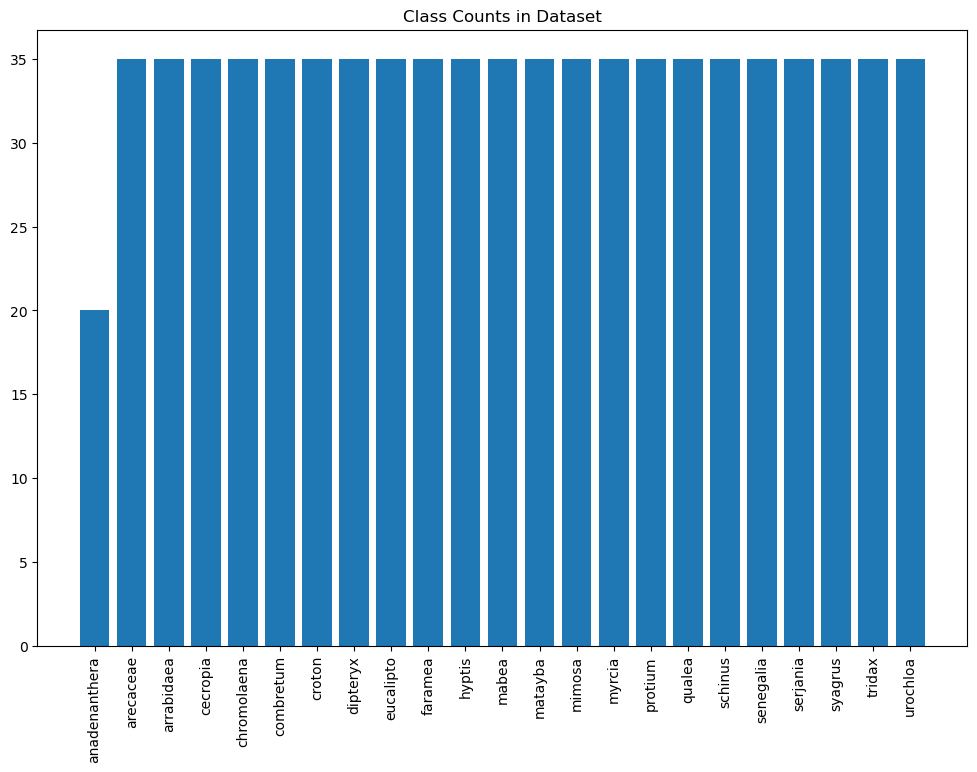

In [3]:
plt.figure(figsize = (12,8))
plt.title('Class Counts in Dataset')
plt.bar(*zip(*classes.items()))
plt.xticks(rotation='vertical')
plt.show()

In [4]:
path_class  = {key:[] for key in classes.keys()}

for name in os.listdir(path):
    key = name.replace(' ', '_').split('_')[0]
    path_class[key].append(path + name)

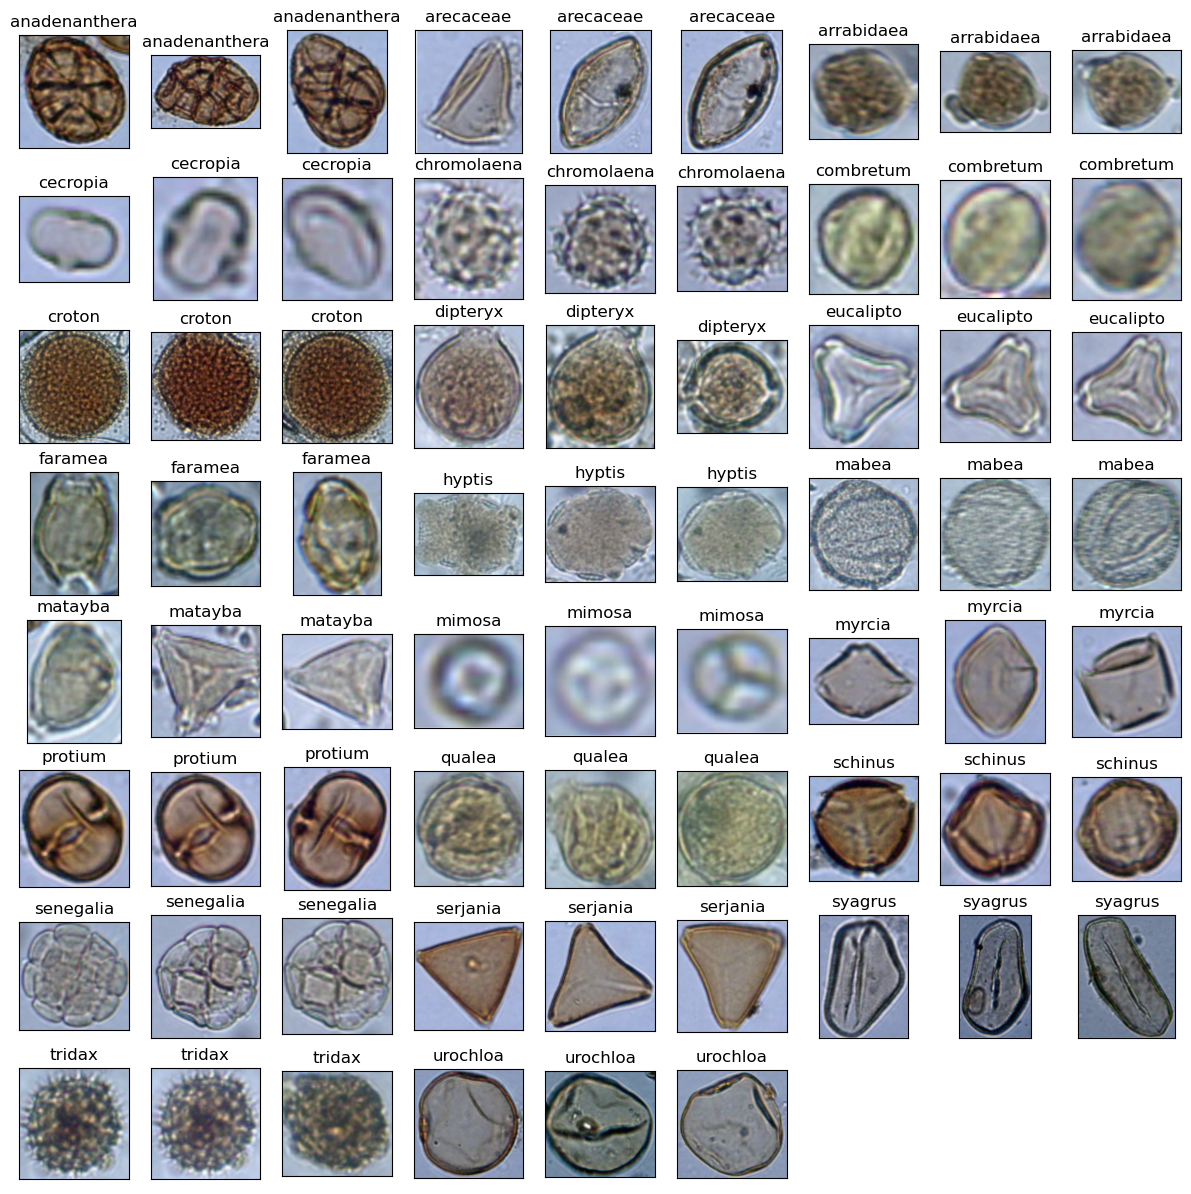

In [5]:
fig = plt.figure(figsize=(15, 15))
for i, key in enumerate(path_class.keys()):
    img1 = Image.open(path_class[key][0]) 
    img2 = Image.open(path_class[key][1]) 
    img3 = Image.open(path_class[key][2]) 

    ax = fig.add_subplot(8, 9,  3*i + 1, xticks=[], yticks=[])
    ax.imshow(img1)
    ax.set_title(key)
    
    ax = fig.add_subplot(8, 9,  3*i + 2, xticks=[], yticks=[])
    ax.imshow(img2)
    ax.set_title(key)

    ax = fig.add_subplot(8, 9,  3*i + 3, xticks=[], yticks=[])
    ax.imshow(img3)
    ax.set_title(key)

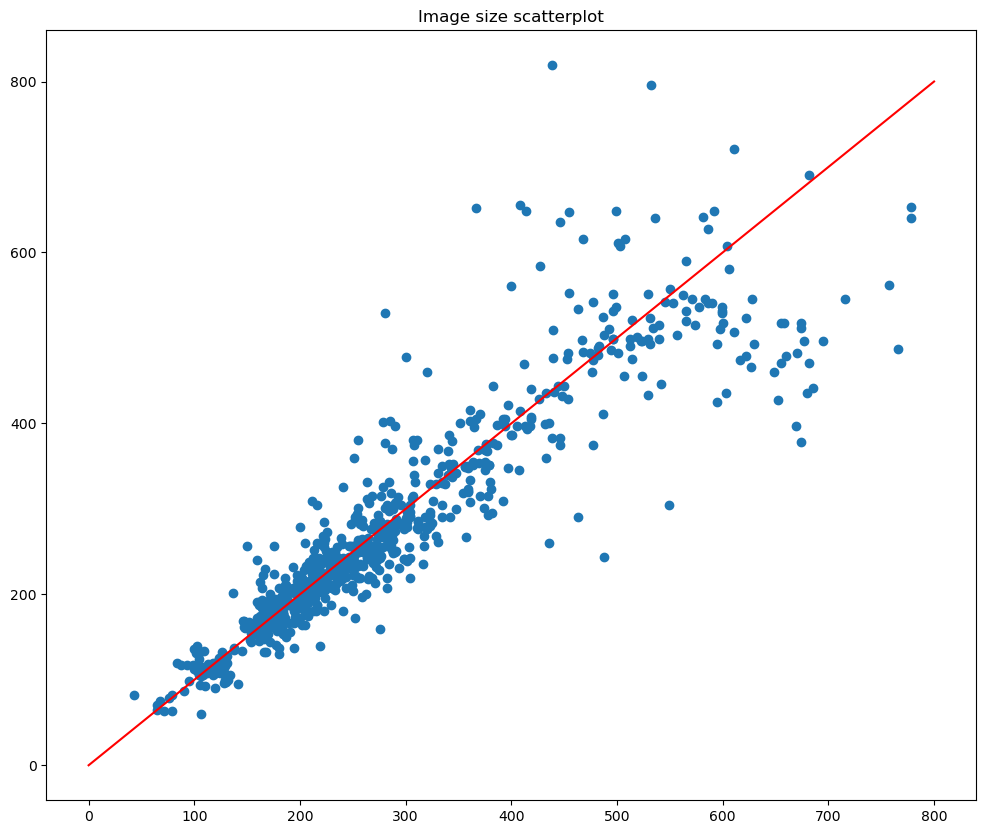

In [6]:
size = [cv2.imread(path + name).shape for name in os.listdir(path)]
x, y, _ = zip(*size)

fig = plt.figure(figsize=(12, 10))

plt.scatter(x,y)
plt.title("Image size scatterplot")

plt.plot([0,800],[0,800], 'r')

In [7]:
def process_img(img, size = (128,128)):
    img = cv2.resize(img, size)  
    img = img/255                   # devide values to 255
    return img   

In [8]:
# Read all images and put in X variable, Y variable is class names
X, Y = [], []
for name  in os.listdir(path):
    img = cv2.imread(path + name)
    X.append(process_img(img))
    Y.append(name.replace(' ', '_').split('_')[0])

X = np.array(X)

In [9]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

le = LabelEncoder()
Y_le = le.fit_transform(Y)
Y_cat = np_utils.to_categorical(Y_le, 23)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y_cat, test_size=0.285, stratify=Y_le)
print("Images in each class in Test set: {}".format(np.sum(Y_test, axis =0)))

Images in each class in Test set: [ 6. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10.]


In [11]:
input_shape =  X_train[0].shape
output_shape = 23

model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 3, input_shape = input_shape, activation= 'relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 32, kernel_size = 2, activation= 'relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 64, kernel_size = 2, activation= 'relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 128, kernel_size = 2, activation= 'relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(500, activation = 'relu'))
# model.add(Dropout(0.2))
model.add(Dense(150, activation = 'relu'))
# model.add(Dropout(0.2))
model.add(Dense(output_shape, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

In [12]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
print('Model is Compiled!')

Model is Compiled!


In [13]:
datagener = ImageDataGenerator(
                rotation_range= 20,
                width_shift_range = 0.2,
                height_shift_range = 0.2,
                horizontal_flip = True,
                vertical_flip = True,)
# fit data generator
datagener.fit(X_train)

In [14]:
batch_size = 4
epochs = 500

model_path = 'cnn.hdf5'
callbecks = [EarlyStopping(monitor ='val_loss', patience = 20), 
             ModelCheckpoint(filepath = model_path, save_best_only = True)]


history = model.fit(
        datagener.flow(X_train, Y_train, batch_size=batch_size), 
        batch_size = batch_size, 
        steps_per_epoch = len(X_train) // batch_size,
        epochs = epochs,
        validation_data = (X_train, Y_train),
        callbacks = callbecks,
        verbose = 1)

Epoch 1/500
141/141 [==============================] - 14s 92ms/step - loss: 3.1414 - accuracy: 0.0443 - val_loss: 3.1165 - val_accuracy: 0.0443
Epoch 2/500
141/141 [==============================] - 12s 86ms/step - loss: 2.9850 - accuracy: 0.0674 - val_loss: 2.7038 - val_accuracy: 0.0887
Epoch 3/500
141/141 [==============================] - 12s 87ms/step - loss: 2.7915 - accuracy: 0.0904 - val_loss: 2.8585 - val_accuracy: 0.0691
Epoch 4/500
141/141 [==============================] - 13s 93ms/step - loss: 2.6745 - accuracy: 0.1170 - val_loss: 2.5091 - val_accuracy: 0.1613
Epoch 5/500
141/141 [==============================] - 13s 90ms/step - loss: 2.6042 - accuracy: 0.1259 - val_loss: 2.3202 - val_accuracy: 0.2004
Epoch 6/500
141/141 [==============================] - 12s 84ms/step - loss: 2.4878 - accuracy: 0.1489 - val_loss: 2.3490 - val_accuracy: 0.1862
Epoch 7/500
141/141 [==============================] - 12s 82ms/step - loss: 2.3589 - accuracy: 0.1809 - val_loss: 2.0616 - val_ac

141/141 [==============================] - 12s 83ms/step - loss: 0.7957 - accuracy: 0.7429 - val_loss: 0.3836 - val_accuracy: 0.8723
Epoch 58/500
141/141 [==============================] - 12s 82ms/step - loss: 0.7653 - accuracy: 0.7553 - val_loss: 0.4659 - val_accuracy: 0.8174
Epoch 59/500
141/141 [==============================] - 11s 81ms/step - loss: 0.7784 - accuracy: 0.7411 - val_loss: 0.6087 - val_accuracy: 0.7908
Epoch 60/500
141/141 [==============================] - 12s 82ms/step - loss: 0.7366 - accuracy: 0.7642 - val_loss: 0.4380 - val_accuracy: 0.8316
Epoch 61/500
141/141 [==============================] - 12s 82ms/step - loss: 0.7345 - accuracy: 0.7713 - val_loss: 0.3599 - val_accuracy: 0.8564
Epoch 62/500
141/141 [==============================] - 11s 81ms/step - loss: 0.7495 - accuracy: 0.7553 - val_loss: 0.5837 - val_accuracy: 0.7855
Epoch 63/500
141/141 [==============================] - 11s 81ms/step - loss: 0.7321 - accuracy: 0.7518 - val_loss: 0.7020 - val_accuracy

In [15]:
model.load_weights(model_path)
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test set accuracy: {}'.format(score[1]))

Test set accuracy: 0.8716813921928406


8/8 [==============================] - 0s 38ms/step


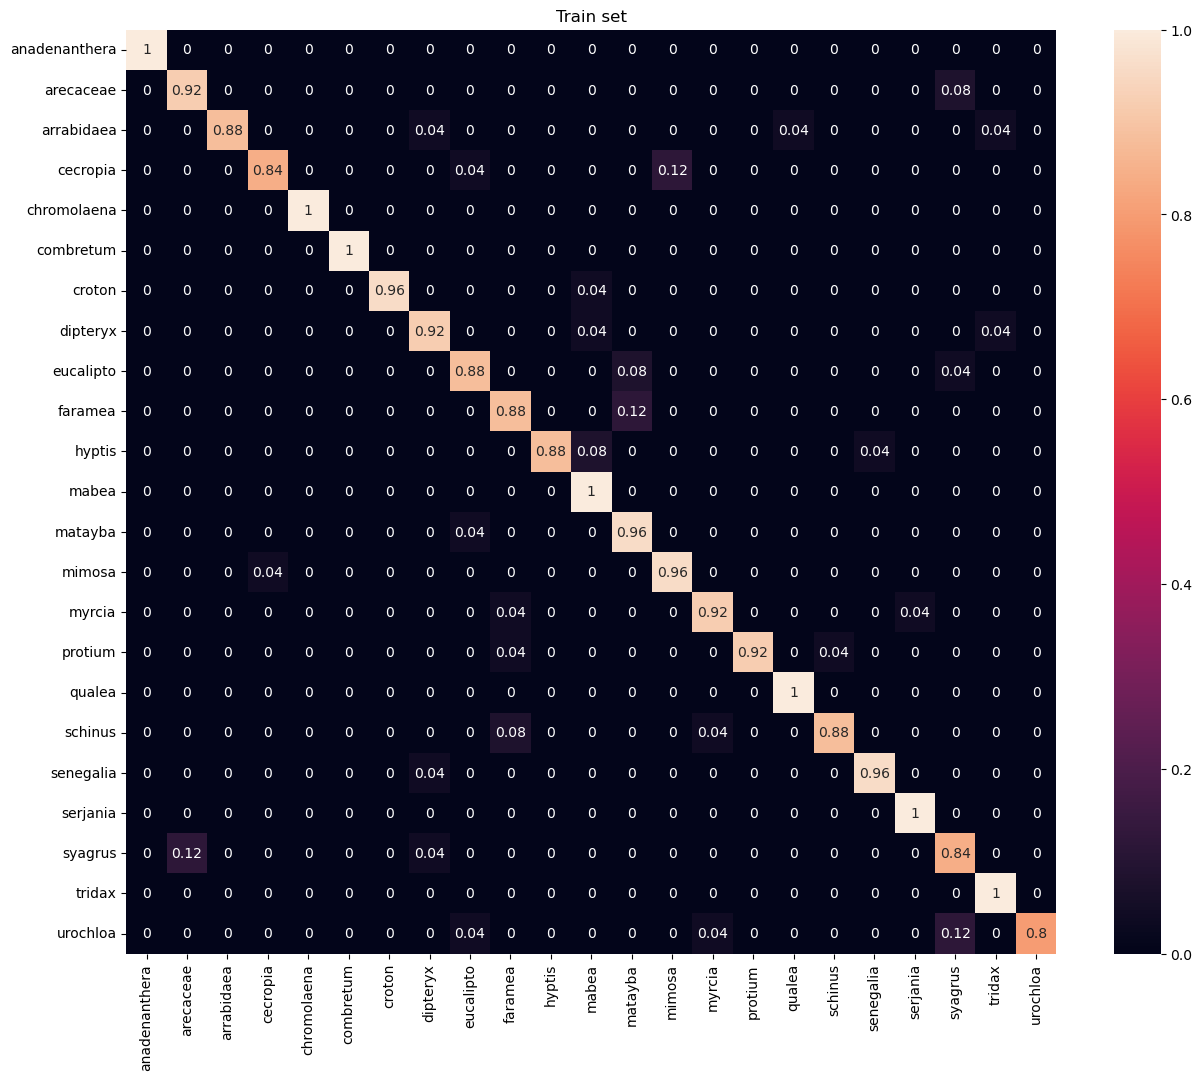

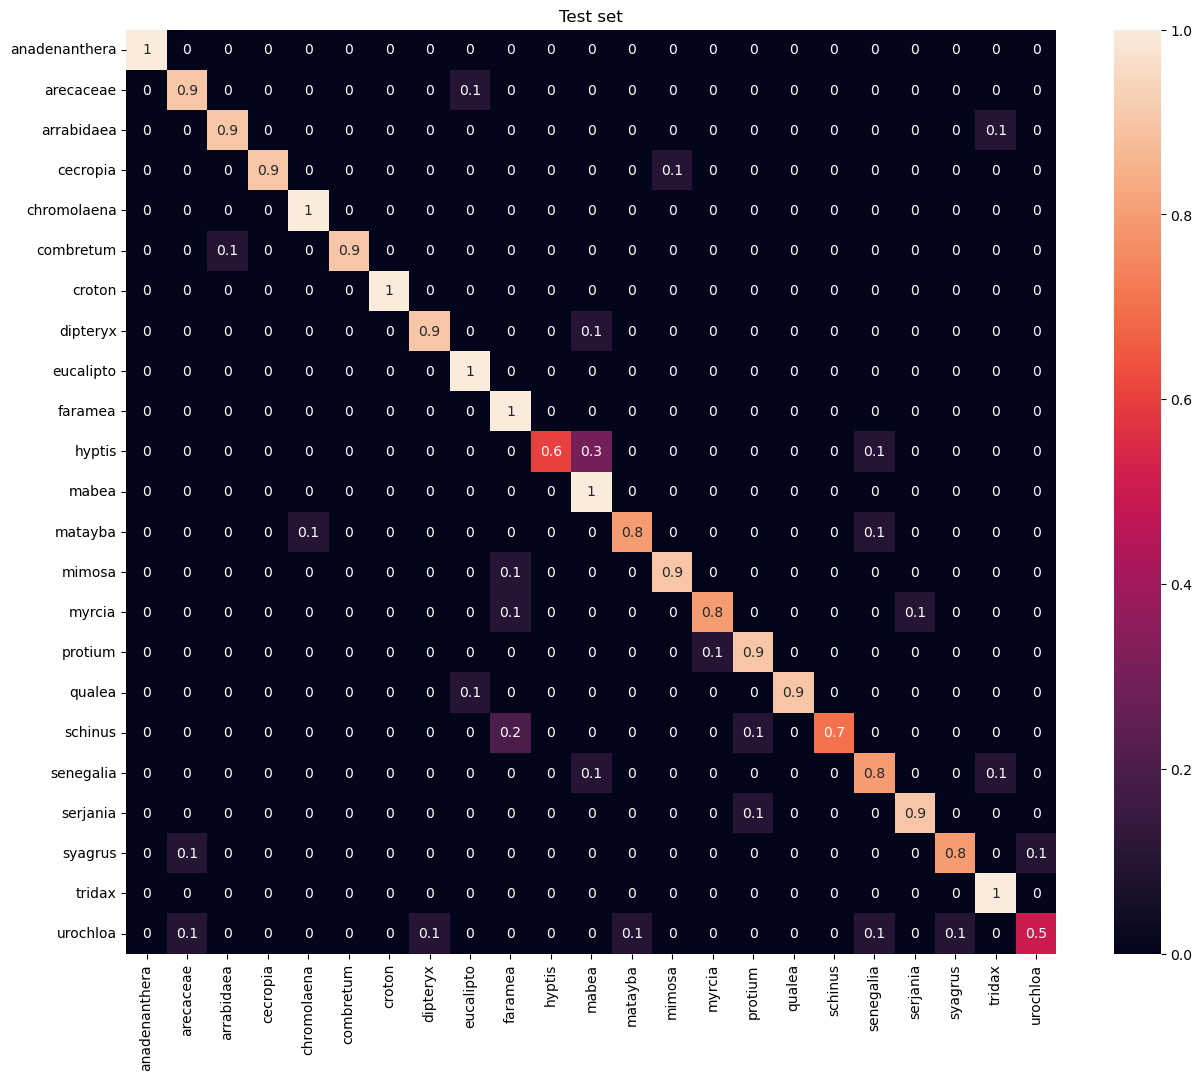

In [16]:
def plot_confusion_matrix(model, x, y, plot_title = ''):
    y_pred = model.predict(x)                            # get predictions on x using model
    predicted_categories = tf.argmax(y_pred, axis=1)     # get index of predicted category
    true_categories = tf.argmax(y, axis=1)               # get index of true category
    # create confusion matrix using sklearn
    cm = confusion_matrix(true_categories, predicted_categories)
    # create DataFrame from the confusion matrix. We retrieve labels from LabelEncoder.
    df_cm = pd.DataFrame(cm, index = le.classes_ ,  columns = le.classes_)
    # divide each row to its sum in the DataFrame to get normalized output
    df_cm = df_cm.div(df_cm.sum(axis=1), axis=0)
    
    plt.figure(figsize = (15,12))
    plt.title(plot_title)
    sns.heatmap(df_cm, annot=True)
    
plot_confusion_matrix(model, X_train, Y_train, "Train set")
plot_confusion_matrix(model, X_test,  Y_test,  "Test set")

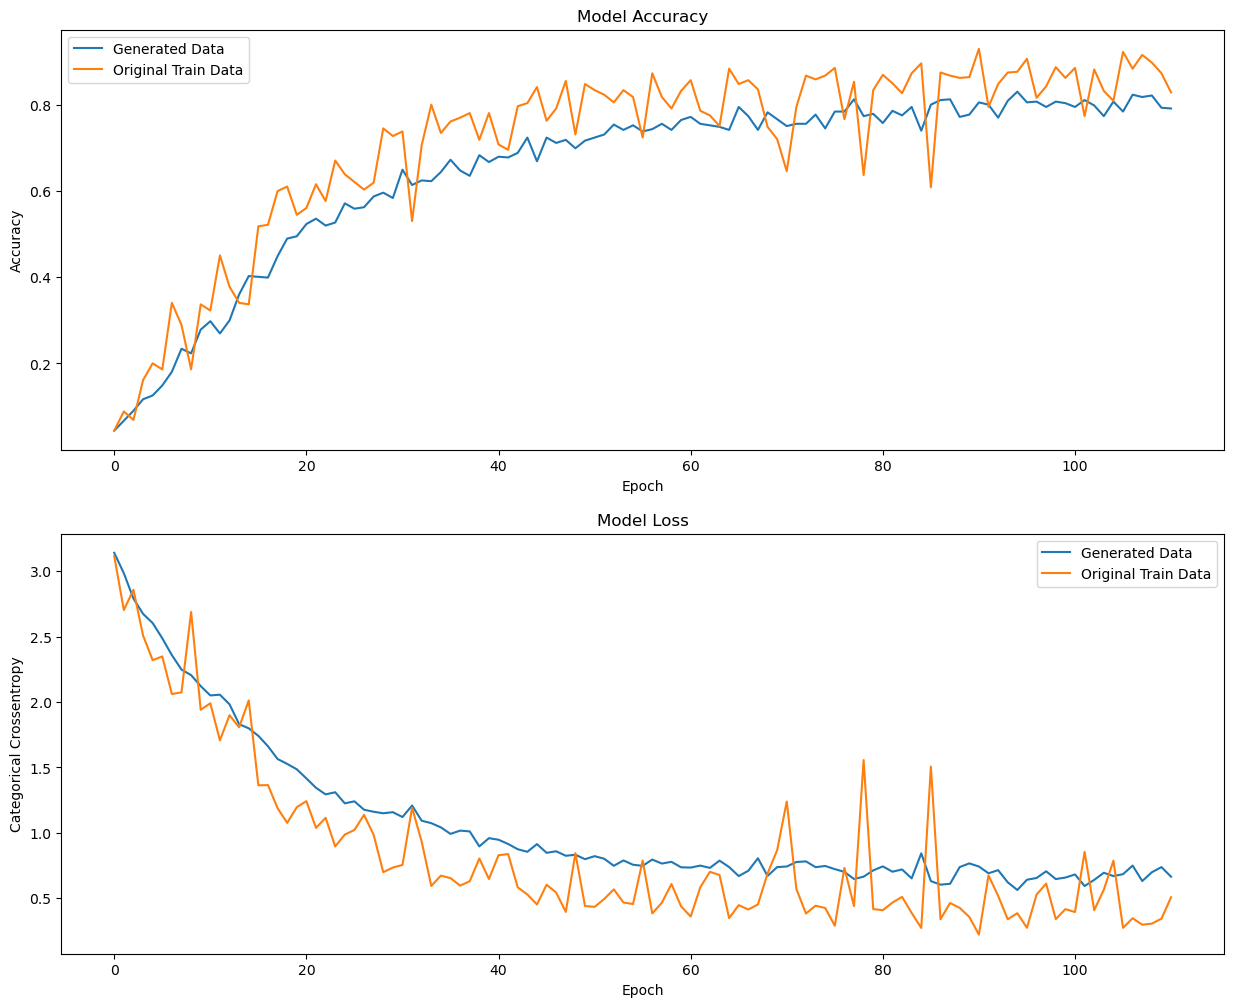

In [17]:
plt.figure(figsize = (15,12))     
   
plt.subplot(211)  
plt.title('Model Accuracy')  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['Generated Data', 'Original Train Data'], loc='best')  
      
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('Categorical Crossentropy')  
plt.xlabel('Epoch')  
plt.legend(['Generated Data', 'Original Train Data'], loc='best')  
plt.show()